#### Magic Commands
Magic commands (those that start with `%`) are commands that modify a configuration of Jupyter Notebooks. A number of magic commands are available by default (see list [here](http://ipython.readthedocs.io/en/stable/interactive/magics.html))--and many more can be added with extensions. The magic command added in this section allows `matplotlib` to display our plots directly on the browser instead of having to save them on a local file.

In [ ]:
%matplotlib inline

# Activity 7: Optimizing a deep learning model
In this activity we optimize our deep learning model. We aim achieve greater performance than our model `bitcoin_lstm_v0`, which is off at about **8.4%** from the real Bitcoin prices. We explore the following topics in this notebook:

* Experimenting with different layers and the number of nodes
* Grid search strategy for epoch and activation functions

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.callbacks import TensorBoard
from keras.layers.core import Dense, Activation, Dropout, ActivityRegularization

Using TensorFlow backend.


In [4]:
from utilities_activity7 import (create_groups, split_lstm_input, 
                               train_model, plot_two_series, rmse, 
                               mape, denormalize)

In [5]:
plt.style.use('seaborn-white')

In [6]:
np.random.seed(0)

### Load Data
We will load our same train and testing set from previous activitites. 

In [7]:
train = pd.read_csv('data/train_dataset.csv')

In [8]:
test = pd.read_csv('data/test_dataset.csv')

In [9]:
train_data = create_groups(
    train['close_point_relative_normalization'].values)

In [10]:
test_data = create_groups(
    test['close_point_relative_normalization'].values)

In [11]:
X_train, Y_train = split_lstm_input(train_data)

### Reference Model
For reference, let's load data for `v0` of our model and train it alongside future modifications.

In [12]:
model_v0 = load_model('bitcoin_lstm_v0.h5')

In [13]:
%%time
train_model(model=model_v0, X=X_train, Y=Y_train, epochs=100, version=0, run_number=0)




Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.4612

Epoch 2/100
1/1 [==============================] - 0s 89ms/step - loss: 0.4389
Epoch 3/100
1/1 [==============================] - 0s 69ms/step - loss: 0.4242
Epoch 4/100
1/1 [==============================] - 0s 57ms/step - loss: 0.4125
Epoch 5/100
1/1 [==============================] - 0s 79ms/step - loss: 0.4027
Epoch 6/100
1/1 [==============================] - 0s 52ms/step - loss: 0.3941
Epoch 7/100
1/1 [==============================] - 0s 100ms/step - loss: 0.3864
Epoch 8/100
1/1 [==============================] - 0s 63ms/step - loss: 0.3794
Epoch 9/100
1/1 [==============================] - 0s 52ms/step - loss: 0.3729
Epoch 10/100
1/1 [==============================] - 0s 53ms/step - loss: 0.3669
Epoch 11/100
1/1 [==============================] - 0s 48ms/step - loss: 0.3612
Epoch 12/100
1/1 [==============================] - 0s 54ms/step - loss: 0.3559
Epoch 13/100
1/1 [============================

Epoch 94/100
1/1 [==============================] - 0s 80ms/step - loss: 0.0551
Epoch 95/100
1/1 [==============================] - 0s 53ms/step - loss: 0.0533
Epoch 96/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0516
Epoch 97/100
1/1 [==============================] - 0s 60ms/step - loss: 0.0499
Epoch 98/100
1/1 [==============================] - 0s 55ms/step - loss: 0.0482
Epoch 99/100
1/1 [==============================] - 0s 68ms/step - loss: 0.0465
Epoch 100/100
1/1 [==============================] - 0s 83ms/step - loss: 0.0449
Wall time: 43.3 s


### Adding Layers and Nodes
We can modify our model to include other layers now. When using LSTM cells, one typically adds other LSTM layer in a sequence. In our case the layer will have the same number of neurons as the original layer.

In order for this to work, however, we need to modify the parameter `return_sequences` to `True` on the first LSTM layer. We do this because the first layer expects a sequence of data with the same as input that the of the first layer. When this parameter is set to `False` the LSTM layer outputs the predicted parameters in a different incompatible output.

In [14]:
period_length = 7
number_of_periods = 76
batch_size=1

In [15]:
model_v1 = Sequential()
model_v1.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

#
#  Add new LSTM layer to this network here.
#
model_v1.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

model_v1.add(Dense(units=period_length))
model_v1.add(Activation("linear"))

model_v1.compile(loss="mse", optimizer="rmsprop")

In [16]:
%%time
train_model(model=model_v1, X=X_train, Y=Y_train, epochs=100, version=1, run_number=0)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.4110
Epoch 2/100
1/1 [==============================] - 0s 111ms/step - loss: 0.3757
Epoch 3/100
1/1 [==============================] - 0s 119ms/step - loss: 0.3532
Epoch 4/100
1/1 [==============================] - 0s 116ms/step - loss: 0.3357
Epoch 5/100
1/1 [==============================] - 0s 112ms/step - loss: 0.3208
Epoch 6/100
1/1 [==============================] - 0s 119ms/step - loss: 0.3074
Epoch 7/100
1/1 [==============================] - 0s 126ms/step - loss: 0.2951
Epoch 8/100
1/1 [==============================] - 0s 120ms/step - loss: 0.2834
Epoch 9/100
1/1 [==============================] - 0s 83ms/step - loss: 0.2721
Epoch 10/100
1/1 [==============================] - 0s 101ms/step - loss: 0.2612
Epoch 11/100
1/1 [==============================] - 0s 109ms/step - loss: 0.2505
Epoch 12/100
1/1 [==============================] - 0s 120ms/step - loss: 0.2401
Epoch 13/100
1/1 [=======================

### Epochs
Epochs are the number of times the network adjust its weights in response to data passing through and its loss function. Running a model for more epochs can allow it to learn more from data, but you also run the risk of overfitting.

When training a model, prefer to increase the epochs exponentially until the loss function starts to plateau. In the case of the `bitcoin_lstm_v0` model, its loss function plateaus at about 100 epochs. If one attempts to train it at 10^3 epochs, the model barely gains any improvements.

In [17]:
#
#  Change the number of epochs below
#  to a higher number (try 10**3) and
#  evaluate the results on TensorBoard.
#
number_of_epochs = 1000

In [18]:
model_v2 = Sequential()
model_v2.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

model_v2.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

model_v2.add(Dense(units=period_length))
model_v2.add(Activation("linear"))

model_v2.compile(loss="mse", optimizer="rmsprop")

In [19]:
%%time
train_model(model=model_v2, X=X_train, Y=Y_train, epochs=number_of_epochs, 
            version=2, run_number=0)

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 0.4270
Epoch 2/1000
1/1 [==============================] - 0s 106ms/step - loss: 0.3992
Epoch 3/1000
1/1 [==============================] - 0s 116ms/step - loss: 0.3831
Epoch 4/1000
1/1 [==============================] - 0s 96ms/step - loss: 0.3710
Epoch 5/1000
1/1 [==============================] - 0s 114ms/step - loss: 0.3611
Epoch 6/1000
1/1 [==============================] - 0s 108ms/step - loss: 0.3525
Epoch 7/1000
1/1 [==============================] - 0s 119ms/step - loss: 0.3447
Epoch 8/1000
1/1 [==============================] - 0s 99ms/step - loss: 0.3375
Epoch 9/1000
1/1 [==============================] - 0s 101ms/step - loss: 0.3308
Epoch 10/1000
1/1 [==============================] - 0s 101ms/step - loss: 0.3244
Epoch 11/1000
1/1 [==============================] - 0s 104ms/step - loss: 0.3183
Epoch 12/1000
1/1 [==============================] - 0s 111ms/step - loss: 0.3123
Epoch 13/1000
1/1 [===========

Epoch 102/1000
1/1 [==============================] - 0s 98ms/step - loss: 0.0182
Epoch 103/1000
1/1 [==============================] - 0s 101ms/step - loss: 0.0172
Epoch 104/1000
1/1 [==============================] - 0s 103ms/step - loss: 0.0162
Epoch 105/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.0153
Epoch 106/1000
1/1 [==============================] - 0s 140ms/step - loss: 0.0144
Epoch 107/1000
1/1 [==============================] - 0s 106ms/step - loss: 0.0136
Epoch 108/1000
1/1 [==============================] - 0s 108ms/step - loss: 0.0127
Epoch 109/1000
1/1 [==============================] - 0s 97ms/step - loss: 0.0119
Epoch 110/1000
1/1 [==============================] - 0s 96ms/step - loss: 0.0111
Epoch 111/1000
1/1 [==============================] - 0s 112ms/step - loss: 0.0104
Epoch 112/1000
1/1 [==============================] - 0s 115ms/step - loss: 0.0096
Epoch 113/1000
1/1 [==============================] - 0s 149ms/step - loss: 0.0090
Epoch 11

Epoch 198/1000
1/1 [==============================] - 0s 166ms/step - loss: 5.0642e-05
Epoch 199/1000
1/1 [==============================] - 0s 149ms/step - loss: 5.0584e-05
Epoch 200/1000
1/1 [==============================] - 0s 218ms/step - loss: 4.7604e-05
Epoch 201/1000
1/1 [==============================] - 0s 168ms/step - loss: 3.6645e-05
Epoch 202/1000
1/1 [==============================] - 0s 127ms/step - loss: 2.7583e-05
Epoch 203/1000
1/1 [==============================] - 0s 97ms/step - loss: 2.0450e-05
Epoch 204/1000
1/1 [==============================] - 0s 110ms/step - loss: 1.6523e-05
Epoch 205/1000
1/1 [==============================] - 0s 150ms/step - loss: 1.3819e-05
Epoch 206/1000
1/1 [==============================] - 0s 119ms/step - loss: 1.2674e-05
Epoch 207/1000
1/1 [==============================] - 0s 153ms/step - loss: 1.2459e-05
Epoch 208/1000
1/1 [==============================] - 0s 104ms/step - loss: 1.3819e-05
Epoch 209/1000
1/1 [========================

Epoch 293/1000
1/1 [==============================] - 0s 105ms/step - loss: 2.0584e-05
Epoch 294/1000
1/1 [==============================] - 0s 146ms/step - loss: 2.3545e-05
Epoch 295/1000
1/1 [==============================] - 0s 166ms/step - loss: 3.0526e-05
Epoch 296/1000
1/1 [==============================] - 0s 110ms/step - loss: 4.3224e-05
Epoch 297/1000
1/1 [==============================] - 0s 98ms/step - loss: 5.2669e-05
Epoch 298/1000
1/1 [==============================] - 0s 93ms/step - loss: 5.4123e-05
Epoch 299/1000
1/1 [==============================] - 0s 171ms/step - loss: 4.4159e-05
Epoch 300/1000
1/1 [==============================] - 0s 170ms/step - loss: 3.3024e-05
Epoch 301/1000
1/1 [==============================] - 0s 115ms/step - loss: 2.2929e-05
Epoch 302/1000
1/1 [==============================] - 0s 140ms/step - loss: 1.7336e-05
Epoch 303/1000
1/1 [==============================] - 0s 109ms/step - loss: 1.4106e-05
Epoch 304/1000
1/1 [=========================

Epoch 388/1000
1/1 [==============================] - 0s 198ms/step - loss: 1.6831e-05
Epoch 389/1000
1/1 [==============================] - 0s 143ms/step - loss: 1.8589e-05
Epoch 390/1000
1/1 [==============================] - 0s 109ms/step - loss: 1.9988e-05
Epoch 391/1000
1/1 [==============================] - 0s 107ms/step - loss: 2.0123e-05
Epoch 392/1000
1/1 [==============================] - 0s 149ms/step - loss: 1.9847e-05
Epoch 393/1000
1/1 [==============================] - 0s 113ms/step - loss: 2.0020e-05
Epoch 394/1000
1/1 [==============================] - 0s 141ms/step - loss: 2.2855e-05
Epoch 395/1000
1/1 [==============================] - 0s 142ms/step - loss: 3.0019e-05
Epoch 396/1000
1/1 [==============================] - 0s 94ms/step - loss: 4.2688e-05
Epoch 397/1000
1/1 [==============================] - 0s 76ms/step - loss: 5.1480e-05
Epoch 398/1000
1/1 [==============================] - 0s 75ms/step - loss: 5.1320e-05
Epoch 399/1000
1/1 [==========================

Epoch 483/1000
1/1 [==============================] - 0s 168ms/step - loss: 2.5529e-05
Epoch 484/1000
1/1 [==============================] - 0s 172ms/step - loss: 2.1328e-05
Epoch 485/1000
1/1 [==============================] - 0s 136ms/step - loss: 1.7752e-05
Epoch 486/1000
1/1 [==============================] - 0s 106ms/step - loss: 1.5471e-05
Epoch 487/1000
1/1 [==============================] - 0s 90ms/step - loss: 1.4383e-05
Epoch 488/1000
1/1 [==============================] - 0s 125ms/step - loss: 1.4876e-05
Epoch 489/1000
1/1 [==============================] - 0s 142ms/step - loss: 1.6448e-05
Epoch 490/1000
1/1 [==============================] - 0s 161ms/step - loss: 1.8412e-05
Epoch 491/1000
1/1 [==============================] - 0s 147ms/step - loss: 1.9505e-05
Epoch 492/1000
1/1 [==============================] - 0s 217ms/step - loss: 1.9610e-05
Epoch 493/1000
1/1 [==============================] - 0s 160ms/step - loss: 1.9297e-05
Epoch 494/1000
1/1 [========================

Epoch 578/1000
1/1 [==============================] - 0s 148ms/step - loss: 2.2155e-05
Epoch 579/1000
1/1 [==============================] - 0s 97ms/step - loss: 2.7908e-05
Epoch 580/1000
1/1 [==============================] - 0s 131ms/step - loss: 3.7535e-05
Epoch 581/1000
1/1 [==============================] - 0s 107ms/step - loss: 4.7394e-05
Epoch 582/1000
1/1 [==============================] - 0s 151ms/step - loss: 4.7158e-05
Epoch 583/1000
1/1 [==============================] - 0s 112ms/step - loss: 3.6792e-05
Epoch 584/1000
1/1 [==============================] - 0s 142ms/step - loss: 2.8196e-05
Epoch 585/1000
1/1 [==============================] - 0s 220ms/step - loss: 2.2136e-05
Epoch 586/1000
1/1 [==============================] - 0s 163ms/step - loss: 1.8161e-05
Epoch 587/1000
1/1 [==============================] - 0s 149ms/step - loss: 1.5071e-05
Epoch 588/1000
1/1 [==============================] - 0s 159ms/step - loss: 1.3521e-05
Epoch 589/1000
1/1 [========================

Epoch 673/1000
1/1 [==============================] - 0s 180ms/step - loss: 1.2430e-05
Epoch 674/1000
1/1 [==============================] - 0s 340ms/step - loss: 1.1420e-05
Epoch 675/1000
1/1 [==============================] - 0s 83ms/step - loss: 1.1434e-05
Epoch 676/1000
1/1 [==============================] - 0s 156ms/step - loss: 1.2180e-05
Epoch 677/1000
1/1 [==============================] - 0s 101ms/step - loss: 1.3294e-05
Epoch 678/1000
1/1 [==============================] - 0s 165ms/step - loss: 1.4925e-05
Epoch 679/1000
1/1 [==============================] - 0s 173ms/step - loss: 1.7013e-05
Epoch 680/1000
1/1 [==============================] - 0s 140ms/step - loss: 1.9948e-05
Epoch 681/1000
1/1 [==============================] - 0s 267ms/step - loss: 2.3759e-05
Epoch 682/1000
1/1 [==============================] - 0s 171ms/step - loss: 2.9876e-05
Epoch 683/1000
1/1 [==============================] - 0s 147ms/step - loss: 3.9873e-05
Epoch 684/1000
1/1 [========================

1/1 [==============================] - 0s 179ms/step - loss: 2.0020e-05
Epoch 768/1000
1/1 [==============================] - 0s 141ms/step - loss: 2.3080e-05
Epoch 769/1000
1/1 [==============================] - 0s 131ms/step - loss: 3.0487e-05
Epoch 770/1000
1/1 [==============================] - 0s 104ms/step - loss: 4.2575e-05
Epoch 771/1000
1/1 [==============================] - 0s 102ms/step - loss: 4.8140e-05
Epoch 772/1000
1/1 [==============================] - 0s 139ms/step - loss: 4.3827e-05
Epoch 773/1000
1/1 [==============================] - 0s 150ms/step - loss: 3.3846e-05
Epoch 774/1000
1/1 [==============================] - 0s 171ms/step - loss: 2.4715e-05
Epoch 775/1000
1/1 [==============================] - 0s 149ms/step - loss: 1.7551e-05
Epoch 776/1000
1/1 [==============================] - 0s 137ms/step - loss: 1.3625e-05
Epoch 777/1000
1/1 [==============================] - 0s 136ms/step - loss: 1.1736e-05
Epoch 778/1000
1/1 [==============================] - 0s 1

Epoch 862/1000
1/1 [==============================] - 0s 138ms/step - loss: 2.3856e-05
Epoch 863/1000
1/1 [==============================] - 0s 131ms/step - loss: 1.7885e-05
Epoch 864/1000
1/1 [==============================] - 0s 166ms/step - loss: 1.3838e-05
Epoch 865/1000
1/1 [==============================] - 0s 121ms/step - loss: 1.1519e-05
Epoch 866/1000
1/1 [==============================] - 0s 108ms/step - loss: 1.0776e-05
Epoch 867/1000
1/1 [==============================] - 0s 133ms/step - loss: 1.1213e-05
Epoch 868/1000
1/1 [==============================] - 0s 185ms/step - loss: 1.2561e-05
Epoch 869/1000
1/1 [==============================] - 0s 148ms/step - loss: 1.4410e-05
Epoch 870/1000
1/1 [==============================] - 0s 141ms/step - loss: 1.6288e-05
Epoch 871/1000
1/1 [==============================] - 0s 117ms/step - loss: 1.7912e-05
Epoch 872/1000
1/1 [==============================] - 0s 104ms/step - loss: 1.9441e-05
Epoch 873/1000
1/1 [=======================

Epoch 957/1000
1/1 [==============================] - 0s 211ms/step - loss: 1.2586e-05
Epoch 958/1000
1/1 [==============================] - 0s 133ms/step - loss: 1.3286e-05
Epoch 959/1000
1/1 [==============================] - 0s 200ms/step - loss: 1.4157e-05
Epoch 960/1000
1/1 [==============================] - 0s 162ms/step - loss: 1.5485e-05
Epoch 961/1000
1/1 [==============================] - 0s 114ms/step - loss: 1.7128e-05
Epoch 962/1000
1/1 [==============================] - 0s 144ms/step - loss: 1.9234e-05
Epoch 963/1000
1/1 [==============================] - 0s 156ms/step - loss: 2.1305e-05
Epoch 964/1000
1/1 [==============================] - 0s 151ms/step - loss: 2.3532e-05
Epoch 965/1000
1/1 [==============================] - 0s 122ms/step - loss: 2.5697e-05
Epoch 966/1000
1/1 [==============================] - 0s 154ms/step - loss: 3.0454e-05
Epoch 967/1000
1/1 [==============================] - 0s 124ms/step - loss: 4.2446e-05
Epoch 968/1000
1/1 [=======================

### Activation Functions
Due to its non-linear properties and efficient computation, we will use the `relu` function as this network's activation function. 

In [20]:
#
#  Instead of using a ReLU, visit
#  the Keras official documentation (https://keras.io/activations/)
#  and choose a different function to try (maybe "tanh").
#
activation_function = "tanh"

In [21]:
model_v3 = Sequential()
model_v3.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

model_v3.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

model_v3.add(Dense(units=period_length))
model_v3.add(Activation(activation_function))

model_v3.compile(loss="mse", optimizer="rmsprop")

In [22]:
%%time
train_model(model=model_v3, X=X_train, Y=Y_train, epochs=300, 
            version=3, run_number=0)

Epoch 1/300
1/1 [==============================] - 8s 8s/step - loss: 0.3292
Epoch 2/300
1/1 [==============================] - 0s 102ms/step - loss: 0.2884
Epoch 3/300
1/1 [==============================] - 0s 100ms/step - loss: 0.2588
Epoch 4/300
1/1 [==============================] - 0s 118ms/step - loss: 0.2347
Epoch 5/300
1/1 [==============================] - 0s 107ms/step - loss: 0.2150
Epoch 6/300
1/1 [==============================] - 0s 103ms/step - loss: 0.1989
Epoch 7/300
1/1 [==============================] - 0s 92ms/step - loss: 0.1858
Epoch 8/300
1/1 [==============================] - 0s 122ms/step - loss: 0.1750
Epoch 9/300
1/1 [==============================] - 0s 156ms/step - loss: 0.1659
Epoch 10/300
1/1 [==============================] - 0s 144ms/step - loss: 0.1581
Epoch 11/300
1/1 [==============================] - 0s 119ms/step - loss: 0.1513
Epoch 12/300
1/1 [==============================] - 0s 166ms/step - loss: 0.1452
Epoch 13/300
1/1 [=======================

Epoch 103/300
1/1 [==============================] - 0s 154ms/step - loss: 0.0062
Epoch 104/300
1/1 [==============================] - 0s 123ms/step - loss: 0.0059
Epoch 105/300
1/1 [==============================] - 0s 161ms/step - loss: 0.0055
Epoch 106/300
1/1 [==============================] - 0s 135ms/step - loss: 0.0053
Epoch 107/300
1/1 [==============================] - 0s 107ms/step - loss: 0.0050
Epoch 108/300
1/1 [==============================] - 0s 147ms/step - loss: 0.0047
Epoch 109/300
1/1 [==============================] - 0s 126ms/step - loss: 0.0044
Epoch 110/300
1/1 [==============================] - 0s 138ms/step - loss: 0.0042
Epoch 111/300
1/1 [==============================] - 0s 104ms/step - loss: 0.0039
Epoch 112/300
1/1 [==============================] - 0s 104ms/step - loss: 0.0037
Epoch 113/300
1/1 [==============================] - 0s 99ms/step - loss: 0.0035
Epoch 114/300
1/1 [==============================] - 0s 154ms/step - loss: 0.0033
Epoch 115/300
1/1

Epoch 200/300
1/1 [==============================] - 0s 148ms/step - loss: 1.6002e-05
Epoch 201/300
1/1 [==============================] - 0s 143ms/step - loss: 1.5718e-05
Epoch 202/300
1/1 [==============================] - 0s 99ms/step - loss: 1.5795e-05
Epoch 203/300
1/1 [==============================] - 0s 149ms/step - loss: 1.6223e-05
Epoch 204/300
1/1 [==============================] - 0s 159ms/step - loss: 1.7986e-05
Epoch 205/300
1/1 [==============================] - 0s 150ms/step - loss: 2.0474e-05
Epoch 206/300
1/1 [==============================] - 0s 150ms/step - loss: 2.1639e-05
Epoch 207/300
1/1 [==============================] - 0s 235ms/step - loss: 1.8948e-05
Epoch 208/300
1/1 [==============================] - 0s 172ms/step - loss: 1.5716e-05
Epoch 209/300
1/1 [==============================] - 0s 133ms/step - loss: 1.2798e-05
Epoch 210/300
1/1 [==============================] - 0s 121ms/step - loss: 1.1671e-05
Epoch 211/300
1/1 [==============================] - 0s

Epoch 296/300
1/1 [==============================] - 0s 110ms/step - loss: 1.3275e-05
Epoch 297/300
1/1 [==============================] - 0s 113ms/step - loss: 1.3284e-05
Epoch 298/300
1/1 [==============================] - 0s 174ms/step - loss: 1.4110e-05
Epoch 299/300
1/1 [==============================] - 0s 113ms/step - loss: 1.5230e-05
Epoch 300/300
1/1 [==============================] - 0s 112ms/step - loss: 1.7286e-05
Wall time: 2min 4s


### Regularization Strategies
In this section we implement a `Dropout()` regularization strategy.

In [23]:
model_v4 = Sequential()
model_v4.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

#
#  Implement a Dropout() here.
#
model_v4.add(Dropout(0.2))

model_v4.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

#
#  Implement a Dropout() here too.
#
model_v4.add(Dropout(0.2))

model_v4.add(Dense(units=period_length))
model_v4.add(Activation(activation_function))

model_v4.compile(loss="mse", optimizer="rmsprop")

In [24]:
%%time
train_model(model=model_v4, X=X_train, Y=Y_train, epochs=600, 
            version=3, run_number=0)

Epoch 1/600
1/1 [==============================] - 4s 4s/step - loss: 0.3105
Epoch 2/600
1/1 [==============================] - 0s 146ms/step - loss: 0.2410
Epoch 3/600
1/1 [==============================] - 0s 123ms/step - loss: 0.2970
Epoch 4/600
1/1 [==============================] - 0s 145ms/step - loss: 0.2536
Epoch 5/600
1/1 [==============================] - 0s 131ms/step - loss: 0.2862
Epoch 6/600
1/1 [==============================] - 0s 125ms/step - loss: 0.2114
Epoch 7/600
1/1 [==============================] - 0s 148ms/step - loss: 0.2720
Epoch 8/600
1/1 [==============================] - 0s 115ms/step - loss: 0.2512
Epoch 9/600
1/1 [==============================] - 0s 132ms/step - loss: 0.2272
Epoch 10/600
1/1 [==============================] - 0s 111ms/step - loss: 0.2038
Epoch 11/600
1/1 [==============================] - 0s 143ms/step - loss: 0.2156
Epoch 12/600
1/1 [==============================] - 0s 135ms/step - loss: 0.1830
Epoch 13/600
1/1 [======================

Epoch 103/600
1/1 [==============================] - 0s 100ms/step - loss: 0.0388
Epoch 104/600
1/1 [==============================] - 0s 101ms/step - loss: 0.0028
Epoch 105/600
1/1 [==============================] - 0s 99ms/step - loss: 0.0267
Epoch 106/600
1/1 [==============================] - 0s 117ms/step - loss: 0.0027
Epoch 107/600
1/1 [==============================] - 0s 98ms/step - loss: 0.0026
Epoch 108/600
1/1 [==============================] - 0s 105ms/step - loss: 0.0041
Epoch 109/600
1/1 [==============================] - 0s 116ms/step - loss: 0.0295
Epoch 110/600
1/1 [==============================] - 0s 218ms/step - loss: 0.0392
Epoch 111/600
1/1 [==============================] - 0s 151ms/step - loss: 0.0032
Epoch 112/600
1/1 [==============================] - 0s 351ms/step - loss: 0.0206
Epoch 113/600
1/1 [==============================] - 0s 159ms/step - loss: 0.0994
Epoch 114/600
1/1 [==============================] - 0s 137ms/step - loss: 0.0024
Epoch 115/600
1/1 

Epoch 203/600
1/1 [==============================] - 0s 167ms/step - loss: 0.0016
Epoch 204/600
1/1 [==============================] - 0s 227ms/step - loss: 0.0462
Epoch 205/600
1/1 [==============================] - 0s 136ms/step - loss: 0.0352
Epoch 206/600
1/1 [==============================] - 0s 154ms/step - loss: 0.0760
Epoch 207/600
1/1 [==============================] - 0s 117ms/step - loss: 0.0249
Epoch 208/600
1/1 [==============================] - 0s 69ms/step - loss: 0.0153
Epoch 209/600
1/1 [==============================] - 0s 83ms/step - loss: 0.0250
Epoch 210/600
1/1 [==============================] - 0s 87ms/step - loss: 0.0026
Epoch 211/600
1/1 [==============================] - 0s 138ms/step - loss: 0.1011
Epoch 212/600
1/1 [==============================] - 0s 143ms/step - loss: 0.1156
Epoch 213/600
1/1 [==============================] - 0s 120ms/step - loss: 0.0151
Epoch 214/600
1/1 [==============================] - 0s 135ms/step - loss: 0.0028
Epoch 215/600
1/1 [

Epoch 303/600
1/1 [==============================] - 0s 132ms/step - loss: 0.0097
Epoch 304/600
1/1 [==============================] - 0s 162ms/step - loss: 0.0440
Epoch 305/600
1/1 [==============================] - 0s 111ms/step - loss: 0.0104
Epoch 306/600
1/1 [==============================] - 0s 147ms/step - loss: 0.0012
Epoch 307/600
1/1 [==============================] - 0s 221ms/step - loss: 0.0264
Epoch 308/600
1/1 [==============================] - 0s 160ms/step - loss: 0.0366
Epoch 309/600
1/1 [==============================] - 0s 236ms/step - loss: 0.0540
Epoch 310/600
1/1 [==============================] - 0s 146ms/step - loss: 0.0158
Epoch 311/600
1/1 [==============================] - 0s 317ms/step - loss: 0.0392
Epoch 312/600
1/1 [==============================] - 0s 158ms/step - loss: 0.0120
Epoch 313/600
1/1 [==============================] - 0s 155ms/step - loss: 0.0028
Epoch 314/600
1/1 [==============================] - 0s 224ms/step - loss: 0.0115
Epoch 315/600
1/

Epoch 403/600
1/1 [==============================] - 0s 239ms/step - loss: 0.0114
Epoch 404/600
1/1 [==============================] - 0s 125ms/step - loss: 0.0079
Epoch 405/600
1/1 [==============================] - 0s 164ms/step - loss: 0.0110
Epoch 406/600
1/1 [==============================] - 0s 117ms/step - loss: 0.0085
Epoch 407/600
1/1 [==============================] - 0s 162ms/step - loss: 0.0113
Epoch 408/600
1/1 [==============================] - 0s 115ms/step - loss: 0.0059
Epoch 409/600
1/1 [==============================] - 0s 165ms/step - loss: 0.0229
Epoch 410/600
1/1 [==============================] - 0s 135ms/step - loss: 0.0081
Epoch 411/600
1/1 [==============================] - 0s 160ms/step - loss: 0.0144
Epoch 412/600
1/1 [==============================] - 0s 151ms/step - loss: 0.0046
Epoch 413/600
1/1 [==============================] - 0s 170ms/step - loss: 0.0465
Epoch 414/600
1/1 [==============================] - 1s 979ms/step - loss: 0.0519
Epoch 415/600
1/

Epoch 503/600
1/1 [==============================] - 0s 134ms/step - loss: 0.0145
Epoch 504/600
1/1 [==============================] - 0s 165ms/step - loss: 0.0366
Epoch 505/600
1/1 [==============================] - 0s 145ms/step - loss: 0.0613
Epoch 506/600
1/1 [==============================] - 0s 228ms/step - loss: 0.0295
Epoch 507/600
1/1 [==============================] - 0s 166ms/step - loss: 0.0086
Epoch 508/600
1/1 [==============================] - 0s 258ms/step - loss: 0.0085
Epoch 509/600
1/1 [==============================] - 0s 134ms/step - loss: 0.0224
Epoch 510/600
1/1 [==============================] - 0s 197ms/step - loss: 0.0199
Epoch 511/600
1/1 [==============================] - 0s 171ms/step - loss: 0.0092
Epoch 512/600
1/1 [==============================] - 0s 232ms/step - loss: 0.0044
Epoch 513/600
1/1 [==============================] - 0s 226ms/step - loss: 0.0044
Epoch 514/600
1/1 [==============================] - 0s 157ms/step - loss: 0.0142
Epoch 515/600
1/

## Evaluate Models
After creating the model versions above, we now have to evaluate which model is performing best in our test data. In order to do that we will use three metrics: MSE, RMSE, and MAPE. MSE is used to compare the error rates of the model on each predicted week. RMSE and MAPE are computed for making the model results easier to interpret.

In [25]:
combined_set = np.concatenate((train_data, test_data), axis=1)

In [26]:
def evaluate_model(model, kind='series'):
    """
    Uses Keras model.evaluate() method to compute
    the MSE for all future weeks in period.
    
    Parameters
    ----------
    model: Keras trained model
    
    kind: str, default 'series'
        Kind of evaluation to perform. If 'series', 
        then the model will perform an evaluation 
        over the complete series.
    
    Returns
    -------
    evaluated_weeks: list
        List of MSE values for each evaluated
        test week.
    """
    if kind == 'series':
        predicted_weeks = []
        for i in range(0, test_data.shape[1]):
            input_series = combined_set[0:,i:i+76]
            predicted_weeks.append(model.predict(input_series))

        predicted_days = []
        for week in predicted_weeks:
            predicted_days += list(week[0])

        return predicted_days
    else:
        evaluated_weeks = []
        for i in range(0, test_data.shape[1]):
            input_series = combined_set[0:,i:i+77]

            X_test = input_series[0:,:-1].reshape(1, input_series.shape[1] - 1, 7)
            Y_test = input_series[0:,-1:][0]

            result = model.evaluate(x=X_test, y=Y_test, verbose=0)
            evaluated_weeks.append(result)
            
            return evaluated_weeks


In [27]:
def plot_weekly_mse(series, model_name, color):
    ax = pd.Series(series).plot(drawstyle="steps-post",
                                figsize=(14,4),
                                linewidth=2,
                                color=color,
                                grid=True,
                                label=model_name,
                                alpha=0.7,
                                title='Mean Squared Error (MSE) for Test Data (all models)'.format(
                                       model_name))

    y = [i for i in range(0, len(series))]
    yint = range(min(y), math.ceil(max(y))+1)
    plt.xticks(yint)

    ax.set_xlabel("Predicted Week")
    ax.set_ylabel("MSE")
    
    return ax

Let's plot the weekly MSE.

In [28]:
def plot_weekly_predictions(predicted_days, name, display_plot=True, 
                            variable='close'):
    
    combined = pd.concat([train, test])
    
    last_day = datetime.strptime(train['date'].max(), '%Y-%m-%d')
    list_of_days = []
    for days in range(1, len(predicted_days) + 1):
        D = (last_day + timedelta(days=days)).strftime('%Y-%m-%d')
        list_of_days.append(D)
    
    predicted = pd.DataFrame({
        'date': list_of_days, 
        'close_point_relative_normalization': predicted_days 
    })
    
    combined['date'] = combined['date'].apply(
                    lambda x: datetime.strptime(x, '%Y-%m-%d'))
    
    predicted['date'] = predicted['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    
    observed = combined[combined['date'] > train['date'].max()]
    
    predicted['iso_week'] = predicted['date'].apply(
                            lambda x: x.strftime('%Y-%U'))
    
    predicted_close = predicted.groupby('iso_week').apply(
                            lambda x: denormalize(observed, x))
    
    plot_two_series(observed, predicted_close, 
                    variable=variable,
                    title='{}: Predictions per Week'.format(name))
    
    print('RMSE: {:.4f}'.format(
        rmse(observed[variable][:-3], 
             predicted_close[variable])))

    print('MAPE: {:.1f}%'.format(
        mape(observed[variable][:-3], 
             predicted_close[variable])))

Finally, let's evaluate each one the models trained in this activity in sequence. 

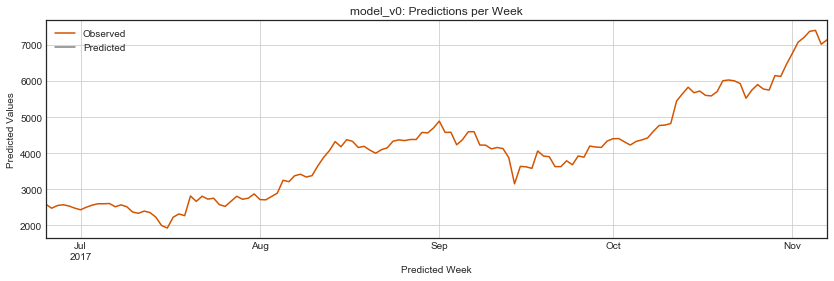

RMSE: 1793.6567
MAPE: 4.3%


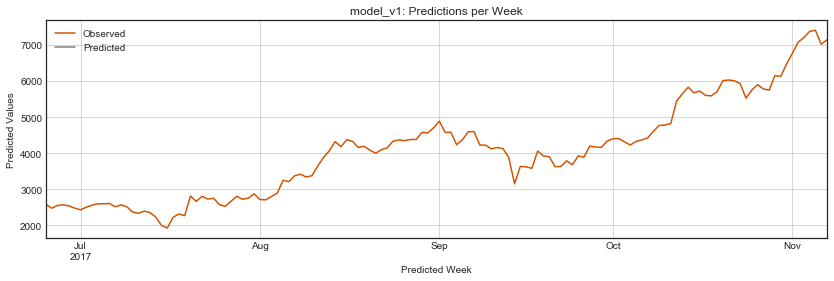

RMSE: 1872.3892
MAPE: 0.2%


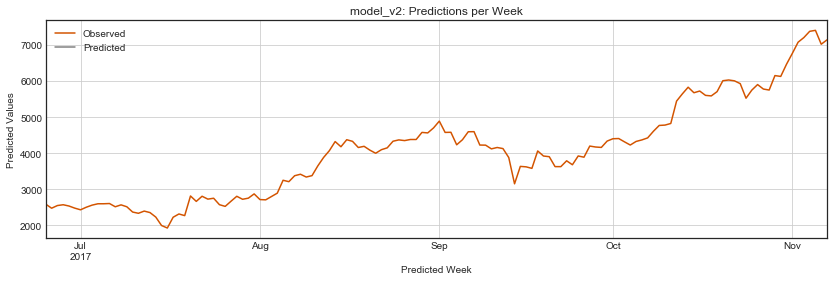

RMSE: 1875.6627
MAPE: 0.0%


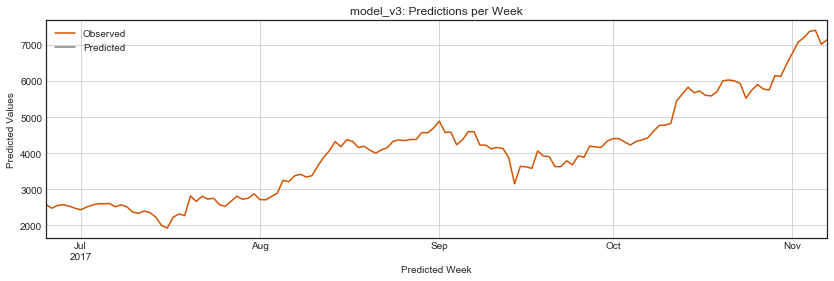

RMSE: 1875.6702
MAPE: 0.0%


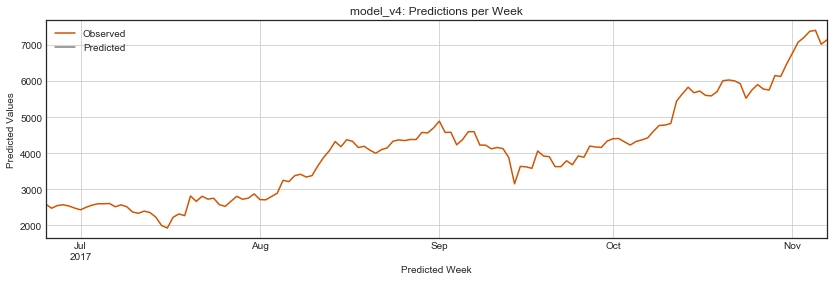

RMSE: 1875.2333
MAPE: 0.0%


In [33]:
models = [model_v0, model_v1, model_v2, model_v3, model_v4]
for i, M in enumerate(models):
    predicted_days = evaluate_model(M, kind='other')
    plot_weekly_predictions(predicted_days, 'model_v{}'.format(i), display_plot=False)

Our first model outperformed all the other models. Take the opportunity and teak the values for the optimization techniques above and attempt to beat the performance of that model!